In [256]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict
import timeit
from IPython.display import display
from tqdm import tqdm_notebook
from sklearn.decomposition import NMF

In [257]:
# load the data
df1 = pd.read_csv('item_properties_part1.csv')
df2 = pd.read_csv('item_properties_part2.csv')

properties_df = pd.concat([df1, df2])
events_df = pd.read_csv('events.csv')
category_df = pd.read_csv('category_tree.csv')

# change timestamp to more useful format
properties_df.timestamp = pd.to_datetime(properties_df.loc[:,'timestamp'], unit='ms')
events_df.timestamp = pd.to_datetime(events_df.loc[:,'timestamp'], unit='ms')

In [258]:
# first look at data
display(properties_df.head())
display(events_df.head())
display(category_df.head())

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [259]:
# We have plenty of rows in properties and only "property" values of "categoryid" and "available" are not hashed
# Thus we decide to remove all rows except where "availalbe" is 1 or we have the "categoryid"
properties_df = properties_df.loc[((properties_df.property == "categoryid") | ((properties_df.property == "available") & (properties_df.value == '1'))),:]

In [260]:
properties_df.property.value_counts()

categoryid    788214
available     640553
Name: property, dtype: int64

In [261]:
properties_df.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
82,2015-06-14 03:00:00,316253,available,1
140,2015-05-24 03:00:00,281245,categoryid,1277
151,2015-06-28 03:00:00,35575,categoryid,1059
167,2015-06-28 03:00:00,139939,available,1


na category values categoryid     0
parentid      25
dtype: int64
number of rows in category df 1669
unique parent 363
unique child 1669
child counts for top 20 parent IDs [31, 22, 22, 19, 18, 17, 15, 15, 13, 13, 13, 12, 12, 11, 11, 10, 10, 10, 10, 10]
view           2664312
addtocart        69332
transaction      22457
dtype: int64


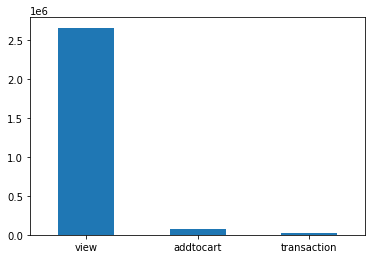

In [262]:
# Data exploration
# check for missing values and look at histograms and counts

# how many na values in category parent and child columns - there are 25 categories with no parent
print('na category values', category_df.isnull().sum(axis = 0))

# number of rows in category df
print('number of rows in category df', category_df.shape[0])

# how many unique parent category ids
print('unique parent', category_df['parentid'].unique().size)

# how many unique child category ids
print('unique child', category_df['categoryid'].unique().size)

# how many children ids to the top parent categories have
n = 20
counts = pd.value_counts(category_df['parentid'].values)
print("child counts for top {} parent IDs".format(n), sorted(counts, reverse=True)[:n])

# clearly events are dominated by views and there are no missing values in the events column
counts = pd.value_counts(events_df['event'].values)
print(counts)
counts.plot.bar(rot=0)

In [263]:
# since there are only 25 rows with nan values in category_df we decide to eliminate them
category_df = category_df.dropna()

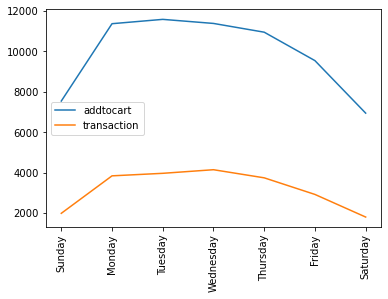

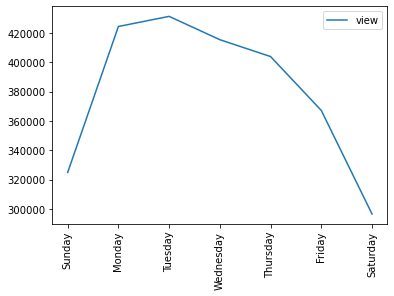

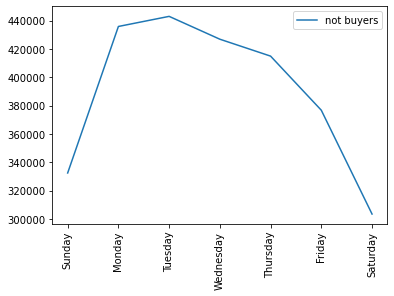

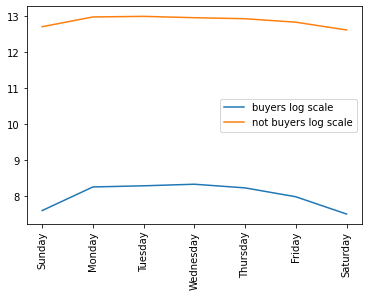

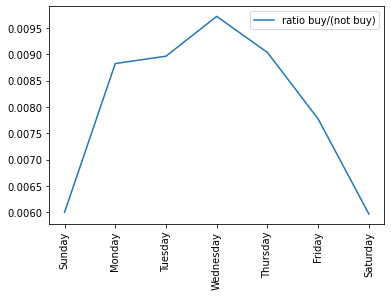

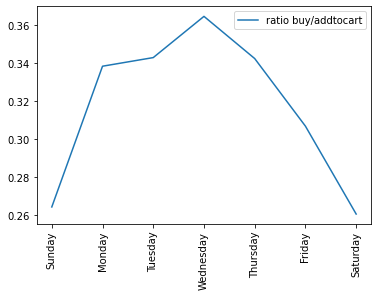

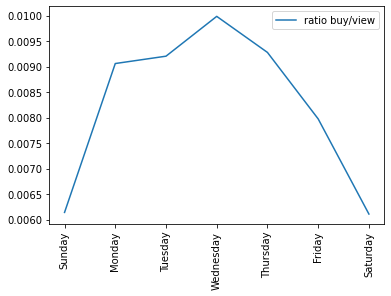

<function matplotlib.pyplot.close(fig=None)>

In [340]:
# we would like to know if days of the week affect puchasing
events_df.timestamp.dt.day_name()
counts = pd.value_counts(events_df['event'].values)
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
x = [1,2,3,4,5,6,7]
view = []
addtocart = []
transaction = []
number_of_visitors = []
not_buyers = []
for day in days:
    counts = pd.value_counts(events_df.loc[events_df.timestamp.dt.day_name() == day,'event'].values)
    number_of_visitors.append(sum(events_df.timestamp.dt.day_name() == day))
#     print(counts)
#     print("not buyers {}".format(number_of_visitors[-1]))
    view.append(counts['view'])
    addtocart.append(counts['addtocart'])
    transaction.append(counts['transaction'])
    not_buyers.append(number_of_visitors[-1] - transaction[-1])
    

plt.plot(x, addtocart, label='addtocart')
plt.plot(x, transaction, label='transaction')
plt.xticks(x,labels=days, rotation='vertical')
plt.legend()
plt.show()
plt.close

plt.plot(x, view, label='view')
plt.xticks(x,labels=days, rotation='vertical')
plt.legend()
plt.show()
plt.close

plt.plot(x, not_buyers, label='not buyers')
plt.xticks(x,labels=days, rotation='vertical')
plt.legend()
plt.show()
plt.close

plt.plot(x, np.log(np.array(transaction)), label='buyers log scale')
plt.plot(x, np.log(np.array(not_buyers)), label='not buyers log scale')
plt.xticks(x,labels=days, rotation='vertical')
plt.legend()
plt.show()
plt.close

plt.plot(x, np.array(transaction)/np.array(not_buyers), label='ratio buy/(not buy)')
plt.xticks(x,labels=days, rotation='vertical')
plt.legend()
plt.show()
plt.close

plt.plot(x, np.array(transaction)/np.array(addtocart), label='ratio buy/addtocart')
plt.xticks(x,labels=days, rotation='vertical')
plt.legend()
plt.show()
plt.close


plt.plot(x, np.array(transaction)/np.array(view), label='ratio buy/view')
plt.xticks(x,labels=days, rotation='vertical')
plt.legend()
plt.show()
plt.close

In [264]:
# we have too many items at the moment - causing too many columns in our ranking matrix
# we determine to remove items that have been viewed fewer than 30 times by all visitors and that have not been added to a cart or purchased
'''
This function takes in events and properties data frames and minimum thresholds for the "event"'s, "view", "addtocart", 
and "transaction" as well as a list for days of the week and returns a data frames that only includes "itemid"'s, products, that have been viewed, added, or purchased
enough times to meet one of the minimum threholds within the days of the week in the days of week list. Basically, we are only looking at items 
that meet a minimum activity requirement. Additionally, we want to be able to separate based on days of the week as much as possible.
Since we have to cut some items for both memory and compuational efficiency it made the most sense to keep "hot" itmes for which rankings
would be the most valuable.
'''
def get_reduced_events(e_df=events_df, p_df=properties_df, view_threshold =  200, add_to_cart_threshold = 40, transaction_threshold = 20,
                      days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']):
    view_counts = pd.value_counts(e_df.loc[e_df.event == 'view', 'itemid'].values)
    add_to_cart_counts = pd.value_counts(e_df.loc[e_df.event == 'addtocart', 'itemid'].values)
    transaction_counts = pd.value_counts(e_df.loc[e_df.event == 'transaction', 'itemid'].values)
    keep_view = view_counts.loc[(view_counts.values >= view_threshold)]
    keep_add_to_cart = add_to_cart_counts.loc[(add_to_cart_counts.values >= add_to_cart_threshold)]
    keep_transaction = transaction_counts.loc[(transaction_counts.values >= transaction_threshold)]
    events_reduced_df = e_df.loc[((e_df.timestamp.dt.day_name().isin(days)) & ((e_df.itemid.isin(keep_view.index)) | (e_df.itemid.isin(keep_add_to_cart.index)) | (e_df.itemid.isin(keep_transaction.index)))),:].copy(deep=True)
    properties_reduced_df = p_df.loc[p_df.timestamp.dt.day_name().isin(days),:].copy(deep=True)
    return events_reduced_df, properties_reduced_df

In [265]:
'''
This fuction takes in the events, properties, and category data frames.
It also takes two boolean parameters for addtocart and transaction events
when these values are true it keeps track of itemids that are either added to cart or purchased in each row
example: if both parameters are set to True and in row 1 items 1105 and 1207 were added to cart and or purchased 
the target value, y_array, whould have the set {1105, 1207} stored as the ground truth for row 1.
Additionally it takes weights for the three event types for a given item, its siblings (items with a common categoryid),
and its cousins (itmes with a common parentid (some categoryids have parentids)).
Finally it has two additional boolean parameters, realtive and distant relative, that turn the checks for siblings and cousins
on and off.
It returns the rank matrix, y_vals and itemids
'''
def get_rank_matrix(e_df=events_df, p_df=properties_df, c_df=category_df, 
                    y_event_add_to_cart=True, y_event_transaction=True,
                    item_view=10, item_add=100, item_purchase=100, 
                    relative_view=5, relative_add=5, relative_purchase=5, relative=False, 
                    distant_relative_view=1, distant_relative_add=2, distant_relative_purchase=2, distant_relative=False,
                   ):
    
    products = np.intersect1d(e_df.itemid.unique(), p_df.itemid.unique(), assume_unique=True)
    e_df = e_df.loc[(e_df.itemid.isin(products)),:].copy(deep=True)
    p_df = p_df.loc[(p_df.itemid.isin(products)),:].copy(deep=True)
    
    visitors = e_df.visitorid.unique()
    
    rank_matrix = np.zeros((visitors.size, products.size))
    
    item_idx_dict = dict(zip(products,range(products.size)))

    y_vals = [set() for x in range(visitors.size)]
    y_events = np.array(['addtocart', 'transaction'])
    y_events = y_events[[y_event_add_to_cart, y_event_transaction]]
    
    print('rank_matrix_size is', rank_matrix.shape)

    events_dict = defaultdict(lambda: defaultdict(lambda: []))
    for event, visitorid, itemid in e_df.loc[:,('event', 'visitorid', 'itemid')].values:
        events_dict[event][visitorid].append(itemid)
    
    if relative or distant_relative:
        common_df = p_df.loc[(p_df.property == 'categoryid'),:].copy(deep=True)
        common_df.value = common_df.copy(deep=True).value.astype(int)
        
        relatives_dict = defaultdict(lambda: set())
        for value, itemid in common_df.loc[:,('value', 'itemid')].values:
            relatives_dict[value].add(itemid)
            
        common_dict = common_df.set_index('itemid').to_dict()['value']
        
        siblings_dict = {}
        for itemid, categoryid in common_dict.items():
            if categoryid in relatives_dict:
                siblings_dict[itemid] = relatives_dict[categoryid] - set([itemid])
                
        if distant_relative:
            category_ids = common_df.value.unique()
            c_df = c_df.loc[(c_df.categoryid.isin(category_ids)),:].copy(deep=True)

            parent_dict = defaultdict(lambda: set())
            for parentid, categoryid in c_df.loc[:,('parentid', 'categoryid')].values:
                parent_dict[parentid].add(categoryid)

            union_dict = c_df.set_index('categoryid').to_dict()['parentid']

            categoryid_siblings_dict = {}
            for categoryid, parentid in union_dict.items():
                if parentid in parent_dict:
                    categoryid_siblings_dict[categoryid] = parent_dict[parentid] - set([categoryid])

            cousins_dict = {}
            for itemid, sibling_set in siblings_dict.items():
                temp_set = set()
                if common_dict[itemid] in categoryid_siblings_dict:
                    for uncle in categoryid_siblings_dict[common_dict[itemid]]:
                        temp_set.update(relatives_dict[uncle])
                cousins_dict[itemid] = temp_set - sibling_set
    
    events = ['view', 'addtocart', 'transaction']
    item_weights = {'view':item_view, 'addtocart':item_add, 'transaction':item_purchase}
    relative_weights = {'view':relative_view, 'addtocart':relative_add, 'transaction':relative_purchase}
    distant_relative_weights = {'view':distant_relative_view, 'addtocart':distant_relative_add, 'transaction':distant_relative_purchase}
    
    for row, visitor in tqdm_notebook(enumerate(visitors), total = len(visitors)):
        for col, product in enumerate(products):
            for event in events:
                if visitor in events_dict[event] and product in events_dict[event][visitor]:
                    rank_matrix[row,col] += item_weights[event]
                    if event in y_events:
                        y_vals[row].add(product)
                    if relative and product in siblings_dict:
                        for sibling in siblings_dict[product]:
                            rank_matrix[row, item_idx_dict[sibling]] += relative_weights[event]
                    if distant_relative and product in cousins_dict:
                        for cousin in cousins_dict[product]:
                            rank_matrix[row, item_idx_dict[cousin]] += distant_relative_weights[event]
        
    return rank_matrix, np.fromiter(item_idx_dict.keys(), dtype=int), y_vals

In [266]:
'''
This function takes in the rank matrix, the numpy array of itemid's used to create the rank matrix
the maximum number of predicted items you want returned for each row and a minimum threhold for rank value.
The minimum threhold must be met for any item to be predicted. If it is not met an empty set is returned for that row
regardless of the number of predicted items selected.
'''
def get_y_predict(rank_matrix, item_ids, num_top_vals=2, event_threshold=5):
    index_array = np.argpartition(rank_matrix, num_top_vals)[:,-num_top_vals:]
    y_predict = [set() for x in range(rank_matrix.shape[0])]
    for row, indices in enumerate(index_array):
        for idx in indices:
            if rank_matrix[row,idx] > event_threshold:
                y_predict[row].add(item_ids[idx])
    return y_predict

In [267]:
def create_recommender(rank_matrix, n_components = 50):
    model = NMF(verbose=1, n_components=n_components)
    W = model.fit_transform(rank_matrix)
    H = model.components_
    return np.dot(W,H)

In [268]:
def generate_recommendations(recommender, item_ids):
    y_predict = [set() for x in range(recommender.shape[0])]
    for index,row in tqdm_notebook(enumerate(recommender), total=len(recommender)):
        sort_index = np.argsort(row)
        for item in sort_index[-40:]:
            y_predict[index].add(item_ids[item])
    return y_predict

In [269]:
'''
This function takes in the predicted items and compares them to the 
actual addtocart and or transaction items (depending on what was selected)
it returns both a total hit rate ((correct_empty_predictions + correct_positive_predictions)/prediction_count)
and a positive hit rate (correct_positive_predictions/number_of_times_ground_truth_was_not_empty)
Note: a correct positive prediction occurs anytime the intersection between the predection set 
and groundtruth set is not empty thus correctly guessing one of the items in the ground truth set results
in being counted as a correct prediction.
'''
def get_hit_rate(y_vals, y_predict):
    hits = 0
    both_empty = 0
    bought_no_predict = 0
    predict_no_bought = 0
    for idx in range(len(y_predict)):
        if (not y_vals[idx] and not y_predict[idx]):
            both_empty += 1
        elif y_vals[idx]:
            if y_vals[idx].intersection(y_predict[idx]):
                hits += 1
            else:
                bought_no_predict += 1
        else:
            predict_no_bought += 1
    return hits, both_empty, bought_no_predict, predict_no_bought

In [270]:
def print_stats(hits, both_empty, bought_no_predict, predict_no_bought):
    print(hits, bought_no_predict)
    print(predict_no_bought, both_empty)

In [ ]:
reduced_e_df, reduced_p_df = get_reduced_events()
# rank_matrix = get_rank_matrix(e_df=events_df.sample(n=int(.005*events_df.shape[0]), random_state=881))
rank_matrix, itemids, y_vals = get_rank_matrix(e_df=reduced_e_df, p_df=reduced_p_df, relative=True, distant_relative=True, relative_add=0, relative_purchase=0, item_add=0, item_purchase=0, distant_relative_add=0, distant_relative_purchase=0)
# rank_matrix = get_rank_matrix(e_df=events_df.sample(n=int(.005*events_df.shape[0]), random_state=881))
rank_matrix_no_distant_relatives, itemids, y_vals = get_rank_matrix(e_df=reduced_e_df, p_df=reduced_p_df, relative=True, distant_relative=False, relative_add=0, relative_purchase=0, item_add=0, item_purchase=0, distant_relative_add=0, distant_relative_purchase=0)
# rank_matrix = get_rank_matrix(e_df=events_df.sample(n=int(.005*events_df.shape[0]), random_state=881))
rank_matrix_no_relatives, itemids, y_vals = get_rank_matrix(e_df=reduced_e_df, p_df=reduced_p_df, relative=False, distant_relative=False, relative_add=0, relative_purchase=0, item_add=0, item_purchase=0, distant_relative_add=0, distant_relative_purchase=0)

rank_matrix_size is (237219, 1125)


<ipython-input-265-2565c52d33ba>:83: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row, visitor in tqdm_notebook(enumerate(visitors), total = len(visitors)):


In [17]:
recommender = create_recommender(rank_matrix)

violation: 1.0
violation: 0.09008997388896264
violation: 0.028537218207368615
violation: 0.015283818699460112
violation: 0.006244506730191577
violation: 0.003620382659680909
violation: 0.0025896209832091603
violation: 0.0021610184847658132
violation: 0.0020729363876573247
violation: 0.0020369566475193384
violation: 0.0019766130982818205
violation: 0.0018375095150221087
violation: 0.0016149019702066667
violation: 0.001360067616237592
violation: 0.0011269285351876988
violation: 0.0009373095696799618
violation: 0.0007926001394366416
violation: 0.0006853540424655603
violation: 0.0006062879744338646
violation: 0.0005542271023560266
violation: 0.0005071953979042146
violation: 0.00047018406345742834
violation: 0.00043934048434703907
violation: 0.0004125348154419259
violation: 0.0003895219185946414
violation: 0.00036979474933552555
violation: 0.0003526640428479807
violation: 0.0003364011116117126
violation: 0.0003220889947017328
violation: 0.00031019447877967066
violation: 0.000301921347241579

In [18]:
recs = generate_recommendations(recommender, itemids)

In [19]:
hits, both_empty, bought_no_predict, predict_no_bought = get_hit_rate(y_vals, recs)
hits/(bought_no_predict + hits)

0.8211453744493392

In [50]:
recs = generate_recommendations(rank_matrix, itemids)

In [51]:
hits, both_empty, bought_no_predict, predict_no_bought = get_hit_rate(y_vals, recs)
a = hits/(bought_no_predict + hits)
a

0.8448360254527656

In [24]:
recs = generate_recommendations(rank_matrix_no_distant_relatives, itemids)

In [25]:
hits, both_empty, bought_no_predict, predict_no_bought = get_hit_rate(y_vals, recs)
c =hits/(bought_no_predict + hits)
c

0.8427802251590798

In [22]:
recs = generate_recommendations(rank_matrix_no_relatives, itemids)

In [23]:
hits, both_empty, bought_no_predict, predict_no_bought = get_hit_rate(y_vals, recs)
b = hits/(bought_no_predict + hits)
b

0.836808614782183

In [58]:
reduced_matrix = rank_matrix
indices = np.where(np.isfinite(reduced_matrix).ravel())[0]
to_replace = np.random.permutation(indices)[:int(indices.size * 0.1)]
reduced_matrix[np.unravel_index(to_replace, reduced_matrix.shape)] = 0

In [59]:
recs = generate_recommendations(reduced_matrix, itemids)
hits, both_empty, bought_no_predict, predict_no_bought = get_hit_rate(y_vals, recs)
d = hits/(bought_no_predict + hits)
d

0.5595692608908468

In [65]:
recommender = create_recommender(reduced_matrix, n_components=200)
recs = generate_recommendations(recommender, itemids)
hits, both_empty, bought_no_predict, predict_no_bought = get_hit_rate(y_vals, recs)
e = hits/(bought_no_predict + hits)
e

0.6581497797356828